In [1]:
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils ,models
import torchvision
from PIL import Image, ImageFilter
import matplotlib.patches as patches

In [ ]:



### here I used convert.ipynb and create_imamges.ipnyb for data augmentation.




In [16]:
tf = pd.read_csv('train.csv',header=None)
print(tf.head())

                                                   0     1     2      3      4
0             JPEG_20160517_140621_1000651031832.png  57.0 -13.5  368.0  339.0
1                   1473231510890DeeplearnS11456.png  -1.0  -9.5  494.0  205.0
2                         1476881557883Untitled1.png  32.0  -4.0  548.0  238.0
3  1474264827890cobalt-beyond-the-sea-maxi-dress3...  -1.0   4.0  640.0  190.0
4             JPEG_20160711_113321_1000235741992.png -10.5 -26.0  225.0  400.0


In [17]:
def show_box(image, co, coo):
    fig,ax = plt.subplots(1)
    co[0] = 319 - (co[0]*64)
    co[1] = 239 -  (co[1]*48)
    x = int((int(co[0] - (co[2]*32))/640 )* 224)
    y = int((int(co[1] - (co[3]*24))/480 )* 224)
    width = int((int(co[2]*64)/640 )* 224)
    height = int((int(co[3]*48)/480 )* 224)
    rect = patches.Rectangle((x,y),width,height,fill=False)
    coo[0] = 319 - (coo[0]*64)
    coo[1] = 239 -  (coo[1]*48)
    x = int((int(coo[0] - (coo[2]*32))/640 )* 224)
    y = int((int(coo[1] - (coo[3]*24))/480 )* 224)
    width = int((int(coo[2]*64)/640 )* 224)
    height = int((int(coo[3]*48)/480 )* 224)
    rectq = patches.Rectangle((x,y),width,height,fill=False,color='r')
    ax.add_patch(rect)
    ax.add_patch(rectq)
    ax.imshow(image)
    plt.show()

In [18]:
class givendataset(Dataset):
    """bounding box dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file,header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.frame.iloc[idx, 0])
        image = np.asarray(Image.open(img_name),dtype=float)
        image = torch.Tensor(image/255)    
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(image)   
        coordinates = self.frame.iloc[idx, 1:].values
        coordinates = coordinates.astype('float')#.reshape(-1, 4)
        sample = {'image': image, 'coordinates': coordinates}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [19]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, coordinates = sample['image'], sample['coordinates']
        # swap color axis because numpy image: H x W x C torch image: C X H X W
        co =torch.from_numpy(coordinates).type(torch.FloatTensor)
        co = torch.div(co,torch.tensor([64.0,48.0,64.0,48.0])) #converting each value to  -10 to  10
        image = image.numpy().transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.FloatTensor),'coordinates': co}

In [24]:
traindataset = givendataset(csv_file='train.csv',
                                           root_dir='images/',
                                           transform=transforms.Compose([ToTensor()]) )
validdataset = givendataset(csv_file='valid.csv',
                                           root_dir='images/',
                                           transform=transforms.Compose([ToTensor()]) )
testdataset = givendataset(csv_file='test.csv',
                                           root_dir='images/',
                                           transform=transforms.Compose([ToTensor()]) )

In [22]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=64, 
                                            shuffle=True)
valid_loader = torch.utils.data.DataLoader(validdataset,batch_size=64, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=64, 
                                             shuffle=True)

In [23]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512,4)
print(model)
torch.cuda.empty_cache()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
#check output size
for i in train_loader:
    data = i['image'].type(torch.FloatTensor)
    target = i['coordinates'].type(torch.FloatTensor)
    output = model(data)
    print(output.shape)
    break

torch.Size([64, 4])


In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    model.cuda()
criterion = torch.nn.L1Loss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def getx(x):
    if x < 0:
        return 0
    if x > 639:
        return 639
    return x
def gety(y):
    if y < 0:
        return 0
    if y > 479:
        return 479
    return y
def get_co(coo):
    x = getx(int(319 - (coo[0]*64)))
    y = gety(int(239 - (coo[1]*48)))
    width = int(coo[2]*64)
    height = int(coo[3]*48)
    x1 = getx(int( x - (width/2)))
    x2 = getx(int( x + (width/2)))
    y1 = gety(int( y - (height/2)))
    y2 = gety(int( y + (height/2)))
    return [x1,x2,y1,y2]

In [ ]:
def calculateIOU(co,coo):
    x1 = get_co(co)
    x2 = get_co(coo)
    x_left   = max(x1[0],x2[0])
    y_top    = max(x1[2],x2[2])
    x_right  = min(x1[1],x2[1])
    y_bottom = min(x1[3],x2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    in_area = (x_right - x_left) * (y_bottom - y_top)
    area0 = (x1[1] -x1[0])*(x1[3]-x1[2])
    area1 = (x2[1] -x2[0])*(x2[3]-x2[2])
    union = float(area0 + area1 - in_area)
    if union==0:
        union+=0.0000002
    iou = in_area / float(union)
    return int(iou * 100)

In [ ]:
def done():
  model.eval()
  #model.cpu()
  lis = []
  for i in test_loader:
      data = i['image'].type(torch.FloatTensor)
      target = i['coordinates'].type(torch.FloatTensor)
      if train_on_gpu: # move tensors to GPU if CUDA is available
          data, target = data.cuda(), target.cuda()
      output = model(data)# forward pass: compute predicted outputs by passing inputs to the model
      iou = float(0)
      for j in range(data.shape[0]):
          p = target[j].cpu().numpy()
          q = output[j].cpu().detach().numpy()
          iou+=calculateIOU(p,q)
      lis.append(iou /data.shape[0])
  sum_of_ious = 0
  for j in lis:
      sum_of_ious += j
  print("average IOU on validation set is")
  print(sum_of_ious/len(lis))

In [21]:
n_epochs = 20 # number of epochs to train the model
valid_loss_min = np.inf # track change in validation loss  
for epoch in range(1, n_epochs+1):
    train_loss = 0.0 # keep track of training and validation loss
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    scheduler.step()
    model.train()
    p = 0
    for i in train_loader:
        data = i['image'].type(torch.FloatTensor)
        target = i['coordinates'].type(torch.FloatTensor)
        p = p + 1
        if train_on_gpu: # move tensors to GPU if CUDA is available
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad() # clear the gradients of all optimized variables
        output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # calculate the batch loss
        #print(loss)
        loss.backward() #compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
        train_loss += loss.item()*data.size(0)# update training loss
        if (p)%20==0:
            print(loss) #print loss every 20 batches
    ######################    
    # validate the model #
    ######################
    model.eval()
    for i in valid_loader:
        data = i['image'].type(torch.FloatTensor)
        target = i['coordinates'].type(torch.FloatTensor)
        if train_on_gpu: # move tensors to GPU if CUDA is available
            data, target = data.cuda(), target.cuda()
        output = model(data)# forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target)# calculate the batch loss
        valid_loss += loss.item()*data.size(0) # update average validation loss 
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    done()

tensor(0.7945, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.7149, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.6329, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.5411, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.5702, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4485, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.3651, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4310, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4533, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4178, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4145, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.3546, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.3509, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.3671, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4139, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.4263, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.3110,

KeyboardInterrupt: ignored

In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    model.cuda()
model.load_state_dict(torch.load('model_cifar.pt'))
#if train_on_gpu:
    #model.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


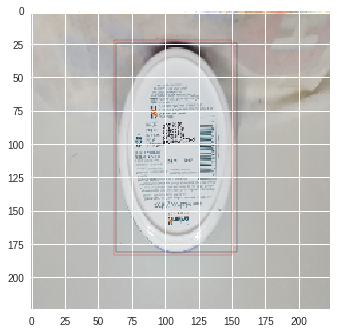

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


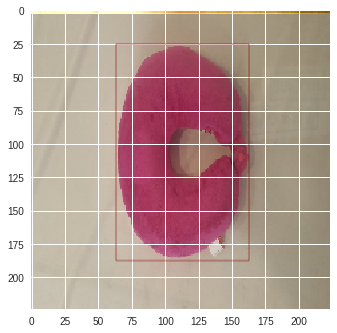

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


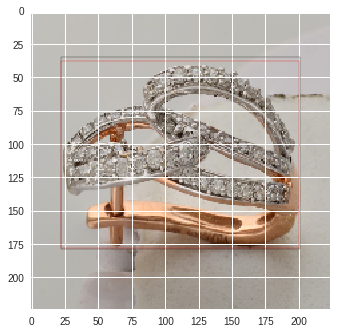

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


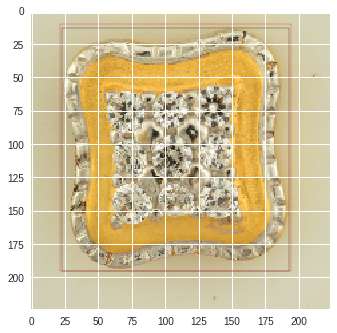

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


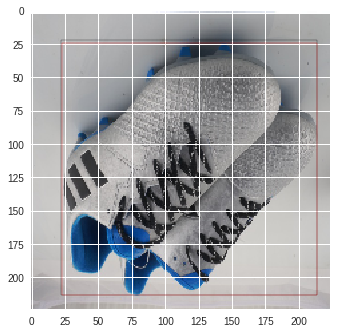

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


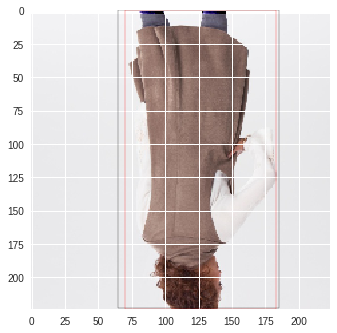

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


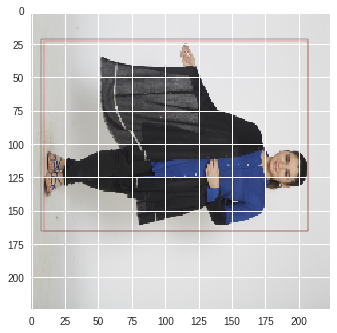

In [22]:
#show some images with boxes red box is prediction
for i in valid_loader:
    data = i['image'].type(torch.FloatTensor)
    target = i['coordinates'].type(torch.FloatTensor)
    if train_on_gpu: # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
    output = model(data)# forward pass: compute predicted outputs by passing inputs to the model
    for j in range(1,8):
        a = data[j].cpu().numpy()
        b = target[j].cpu().numpy()
        c = output[j].cpu().detach().numpy()
        a = a.transpose(1,2,0)
        show_box(a,b,c)
    break